In [4]:
# Manipulación de Datos
# =====================
import numpy as np
import pandas as pd

# Gráficos
# ========
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
sns.set_context('notebook')

# Preprocesado, modelado, metricas
# ================================
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import plot_confusion_matrix
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import recall_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import precision_score
from sklearn.metrics         import make_scorer
from sklearn.metrics         import classification_report

# Configuración de warnings
# =========================
import warnings
warnings.filterwarnings('ignore')


In [5]:
#from google.colab import files
#uploaded = files.upload()


In [6]:
df = pd.read_csv('mkt_bank.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35010 entries, 0 to 35009
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             35010 non-null  int64  
 1   Edad                   35010 non-null  int64  
 2   Trabajo                35010 non-null  object 
 3   Estado civil           35010 non-null  object 
 4   Educacion              35010 non-null  object 
 5   Default                35010 non-null  object 
 6   Prestamo vivienda      35010 non-null  object 
 7   Prestamo personal      35010 non-null  object 
 8   Contacto               35010 non-null  object 
 9   Mes                    35010 non-null  object 
 10  Dia de la semana       35010 non-null  object 
 11  Cantidad de contactos  35010 non-null  int64  
 12  Dias                   35010 non-null  int64  
 13  Anterior               35010 non-null  int64  
 14  Resultado anterior     35010 non-null  object 
 15  em

In [7]:
def clean_data(df):
    df['Educacion'] = df['Educacion'].replace(["basica.9y",
                                               "basica.6y",
                                               "basica.4y"],
                                              "primario")
    
    df['Prestamo vivienda'] = df['Prestamo vivienda'].astype('category')
    df['Prestamo personal'] = df['Prestamo personal'].astype('category')
    df['Default'] = df['Default'].astype('category')
    df['Resultado anterior'] = df['Resultado anterior'].astype('category')
    df['Contacto'] = df['Contacto'].astype('category')
    df['Trabajo'] = df['Trabajo'].astype('category')
    df['Educacion'] = df['Educacion'].astype('category')
    df['Estado civil'] = df['Estado civil'].astype('category')

    days ={'sun' : 1,
           'mon' : 2,
           'tue' : 3,
           'wed' : 4,
           'thu' : 5,
           'fri' : 6,
           'sat' : 7}

    df['Dia de la semana'] = df['Dia de la semana'].apply(lambda x: days[x])

    month = {'jan' : 1,
             'feb' : 2,
             'mar' : 3,
             'apr' : 4,
             'may' : 5,
             'jun' : 6,
             'jul' : 7,
             'aug' : 8,
             'sep' : 9,
             'oct' : 10,
             'nov' : 11,
             'dec' : 12 }
    df['Mes'] = df.Mes.apply(lambda x: month[x])

    df.drop('Unnamed: 0', axis="columns", inplace=True)
    df.drop('nr.employed', axis = 'columns', inplace=True)

    # Reduccion de categorías de la variable Anterior
    series = pd.value_counts(df['Anterior'])
    mask = (series < 650)
    df['Anterior'] = np.where(df['Anterior'].isin(
                        series[mask].index),'2mas',
                         df['Anterior'])
    df['Anterior'] = df['Anterior'].astype('category')

    # Eliminación de registros duplicados
    df.drop_duplicates(inplace = True)

    return df
df = clean_data(df)

In [8]:
#sns.pairplot(df, hue="y")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33558 entries, 0 to 35009
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Edad                   33558 non-null  int64   
 1   Trabajo                33558 non-null  category
 2   Estado civil           33558 non-null  category
 3   Educacion              33558 non-null  category
 4   Default                33558 non-null  category
 5   Prestamo vivienda      33558 non-null  category
 6   Prestamo personal      33558 non-null  category
 7   Contacto               33558 non-null  category
 8   Mes                    33558 non-null  int64   
 9   Dia de la semana       33558 non-null  int64   
 10  Cantidad de contactos  33558 non-null  int64   
 11  Dias                   33558 non-null  int64   
 12  Anterior               33558 non-null  category
 13  Resultado anterior     33558 non-null  category
 14  emp.var.rate           33558 non-null 

In [9]:
y = df['y']
X = df.drop("y",axis="columns")
def preprocess_data(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
    cl = ColumnTransformer(
                   [
                    ('onehot', OneHotEncoder(), cat_cols)],
                remainder = 'passthrough')

    df = cl.fit_transform(df)
    return df

X = preprocess_data(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = y)

In [11]:
def benefitmatrix_score(y,y_pred,**kargs):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return (tn * 200 + tp * 2900 - 440 * fp) / len(y)

In [12]:
def plot_search_results(grid,s):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_'+s]
    stds_test = results['std_test_'+s]
    means_train = results['mean_train_'+s]
    stds_train = results['std_train_'+s]

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle(s+' Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  8.7min finished



{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 300}
Precision Promedio (train):  334.1093645235789
Precision promedio (test):  332.6698450536353
              precision    recall  f1-score   support

          no       0.95      0.88      0.92      5929
          si       0.43      0.66      0.52       783

    accuracy                           0.86      6712
   macro avg       0.69      0.77      0.72      6712
weighted avg       0.89      0.86      0.87      6712



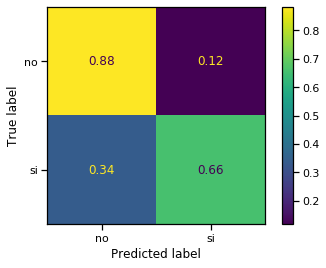

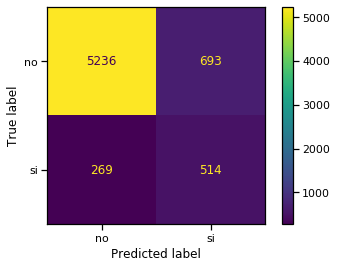

In [13]:
def rf_optimized(X_train, X_test, y_train, y_test):
    n_estimators = [100, 200, 300]
    max_depth = [7, 12, 15]
    min_samples_leaf = [5, 10, 15]
    max_features = ['sqrt', 'auto']
    bootstrap = [True, False]

    hyperparametros = dict(
        n_estimators=n_estimators, 
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        max_features=max_features,
        bootstrap = bootstrap
    )

    algoritmo = RandomForestClassifier(class_weight = 'balanced',
                                       random_state =  42)
    custom_scorer = {"Matriz_de_beneficio" : make_scorer(benefitmatrix_score,
                                                         greater_is_better=True),
                     'Accuracy': make_scorer(accuracy_score)
                     }

    clf = GridSearchCV(algoritmo,
                       hyperparametros,
                       cv                 = 5,
                       verbose            = 4,
                       scoring            = custom_scorer,
                       n_jobs             = -1,
                       refit              = "Matriz_de_beneficio",
                       return_train_score = True)

    # Entrenamiento
    algoritmo = clf.fit(X_train, y_train)
    print()
    print(algoritmo.best_params_)

    # Predicciones
    Y_pred = algoritmo.predict(X_test)
    plot_confusion_matrix(algoritmo, X_train, y_train,normalize='true')
    plot_confusion_matrix(algoritmo,
                          X_test,
                          y_test,
                          values_format  = 'd')

    print("Precision Promedio (train): ", algoritmo.score(X_train, y_train))
    print("Precision promedio (test): ", algoritmo.score(X_test, y_test))
    print(classification_report(y_test, Y_pred))
    return algoritmo

algoritmo_rf = rf_optimized(X_train, X_test, y_train, y_test)

In [ ]:
# si corren otra vez el notebook van a ver los gráficos que estan en el word.
plot_search_results(algoritmo_rf,'Matriz_de_beneficio')
plot_search_results(algoritmo_rf,'Accuracy')

In [ ]:
# Modelo con los mejores hiperparámetros
# Train/Test (80/20)

def rf_optimized(X_train, X_test, y_train, y_test):
    n_estimators     = [300]
    max_depth        = [15]
    min_samples_leaf = [10]
    max_features     = ['sqrt']
    bootstrap        = [True]

    hyperparametros = dict(
                            n_estimators     = n_estimators, 
                            min_samples_leaf = min_samples_leaf,
                            max_depth        = max_depth,
                            max_features     = max_features,
                            bootstrap        = bootstrap
                           )

    algoritmo = RandomForestClassifier(class_weight ='balanced',
                                       random_state = 42)
    
    custom_scorer = {"Matriz_de_beneficio" : make_scorer(benefitmatrix_score,
                                                         greater_is_better=True),
                     'Accuracy': make_scorer(accuracy_score)
                     }

    clf = GridSearchCV(algoritmo,
                       hyperparametros,
                       cv                 = 5,
                       verbose            = 4,
                       scoring            = custom_scorer,
                       n_jobs             = -1,
                       refit              = "Matriz_de_beneficio",
                       return_train_score = True)
    
    # Entrenamiento
    algoritmo = clf.fit(X_train, y_train)
    print()
    print(algoritmo.best_params_)

    # Predicciones
    Y_pred = algoritmo.predict(X_test)

    plot_confusion_matrix(algoritmo,
                          X_test,
                          y_test,
                          values_format  = 'd')
    
    print()
    print("Beneficio promedio (train): {:.2f}".format(algoritmo.score(X_train, y_train)))
    print("Beneficio promedio (test): {:.2f}".format(algoritmo.score(X_test, y_test)))
    print()
    print(classification_report(y_test, Y_pred))
    return algoritmo

algoritmo_rf = rf_optimized(X_train, X_test, y_train, y_test)